In [1]:
# variable for whether running on colab or not
running_on_colab = True

In [2]:
# Import drive and connect
if running_on_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    
    import subprocess
    subprocess.run("pip install pyrsgis", shell=True)
    subprocess.run("pip install matplotlib_scalebar", shell=True)

    # Check GPU
    subprocess.run("nvidia-smi", shell=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.model_selection import train_test_split

import dataImageUtils as diu
import plotEvalUtils as peu

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# constants for program

input_bands = [i+1 for i in range(0,7)]
nBands = len(input_bands)
ndvi_band = 9
labels_band = 8

print('Analyzing bands: ', input_bands)
print('nBands: ', nBands)

downsampleMajority = False

diu.setGlobalVariables(input_bands, nBands)

if running_on_colab: image_base_path = "/content/drive/MyDrive/MangroveClassification/Images/"
else: image_base_path = "../SatelliteImages/"
    
kSize = 7
stride = 1

Analyzing bands:  [1, 2, 3, 4, 5, 6, 7]
nBands:  7


Processing image:  0

First training image NDVI band:


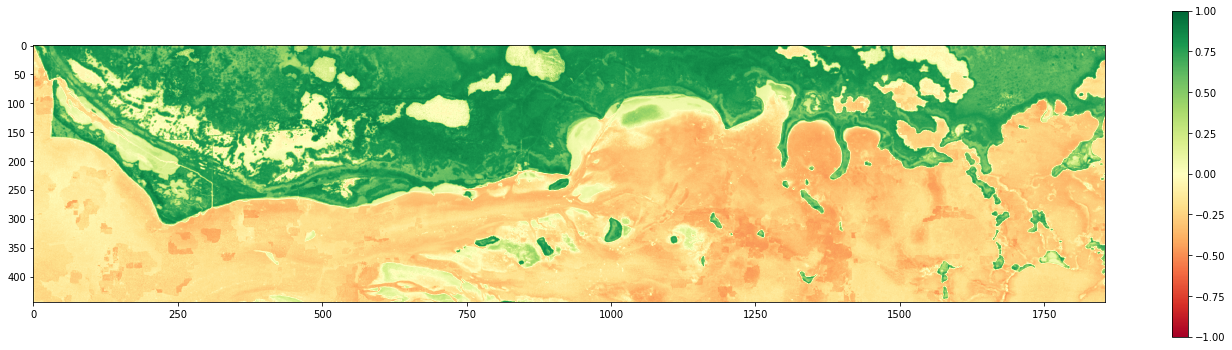


First training image mangroves from labels: 


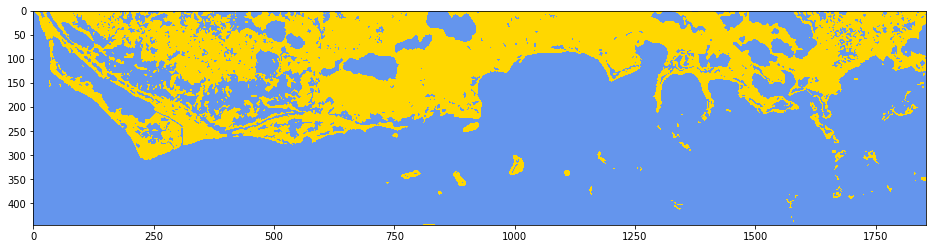

Processing image:  1
Processing image:  2
Using training data of length:  2473681
Class 0: 1795361 Class 1: 678320
Class 0:  72.6% Class 1:  27.4%


In [5]:
# generate training data from chosen images
training_images = []

training_images.append(image_base_path + "Florida_1_2000.tif")
training_images.append(image_base_path + "Florida_3_2000.tif")
training_images.append(image_base_path + "Brazil_2_2000.tif")

model_input_data, model_input_labels = diu.loadTrainingImagesCNN(training_images, downsampleMajority, kSize, stride)

# np.save('features_save_test.npy', model_input_data)
# np.save('labels_save_test.npy', model_input_labels)

In [6]:
# split the data
xTrain, xTest, yTrain, yTest = train_test_split(model_input_data, model_input_labels, test_size=0.4, random_state=42, stratify=model_input_labels, shuffle=True)
print(xTrain.shape)
print(xTest.shape)

# delete some variables to clear up memory
del model_input_data
del model_input_labels

(1484208, 7, 7, 7)
(989473, 7, 7, 7)


In [7]:
# Define the parameters of the model
model = keras.Sequential()
model.add(Conv2D(32, kernel_size=1, padding='valid', activation='relu', input_shape=(kSize, kSize, nBands)))
model.add(Dropout(0.25))
model.add(Conv2D(48, kernel_size=1, padding='valid', activation='relu'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))


# Define the accuracy metrics and parameters
model.compile(optimizer= 'rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 7, 7, 32)          256       
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 48)          1584      
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 48)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2352)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                150592    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0

In [13]:
# fit the model
history = model.fit(xTrain, yTrain, validation_split=0.3, epochs=1)

32468/32468 [==============================] - 119s 4ms/step - loss: 6347787264.0000 - accuracy: 0.9247 - val_loss: 1327475072.0000 - val_accuracy: 0.9346


In [14]:
print(history.history)

# could make some plots of the metrics/convergance - would want to plot the f1 score though instead of accuracy
# fig, ax = plt.subplots()

# mae = history.history['mae']
# val_mae = history.history['val_mae']

# epochs = range(len(mae))

# ax.plot(epochs, mae, label='Train MAE')
# ax.plot(epochs, val_mae, label='Val MAE')

# ax.legend();

{'loss': [6347787264.0], 'accuracy': [0.9247486591339111], 'val_loss': [1327475072.0], 'val_accuracy': [0.9346274137496948]}


Confusion matrix:
 [[682510  35635]
 [ 28453 242875]]

P-Score: 0.872, R-Score: 0.895
Accuracy: 0.935
f1: 0.883
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96    718145
         1.0       0.87      0.90      0.88    271328

    accuracy                           0.94    989473
   macro avg       0.92      0.92      0.92    989473
weighted avg       0.94      0.94      0.94    989473



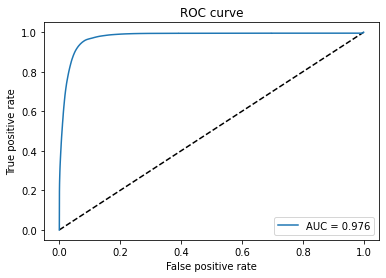

In [15]:
# Predict for test data 
yTest_pred_prob = model.predict(xTest)
yTest_pred_prob = yTest_pred_prob[:,1] # grab probablities for class label 1

peu.printClassificationMetrics(yTest, yTest_pred_prob)
peu.makeROCPlot(yTest, yTest_pred_prob)

Predicting for image: /content/drive/MyDrive/MangroveClassification/Images/Brazil_1_2000.tif

Image NDVI band:


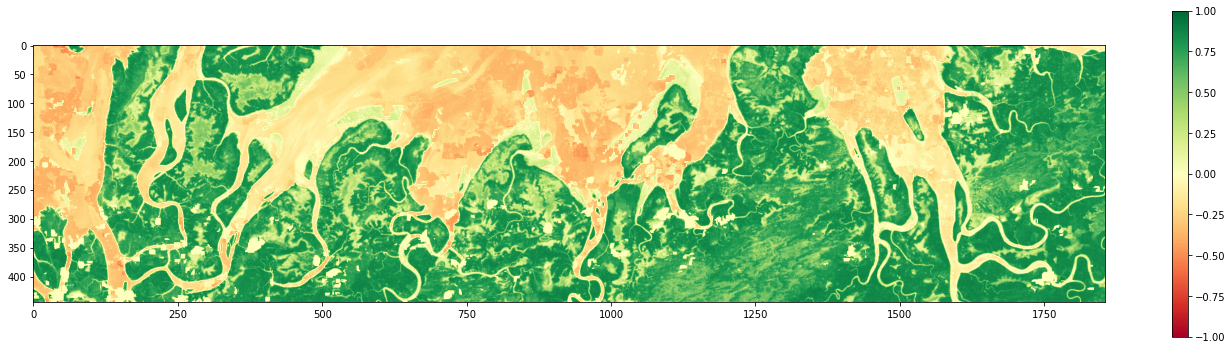


Label mangroves from 2000 data:


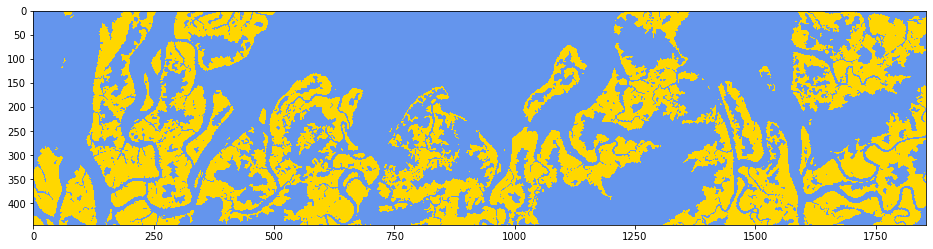

Confusion matrix:
 [[497767  38556]
 [ 55360 233792]]

P-Score: 0.858, R-Score: 0.809
Accuracy: 0.886
f1: 0.833
              precision    recall  f1-score   support

           0       0.90      0.93      0.91    536323
           1       0.86      0.81      0.83    289152

    accuracy                           0.89    825475
   macro avg       0.88      0.87      0.87    825475
weighted avg       0.89      0.89      0.89    825475



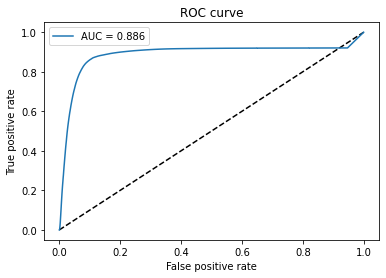


Predicted mangroves:


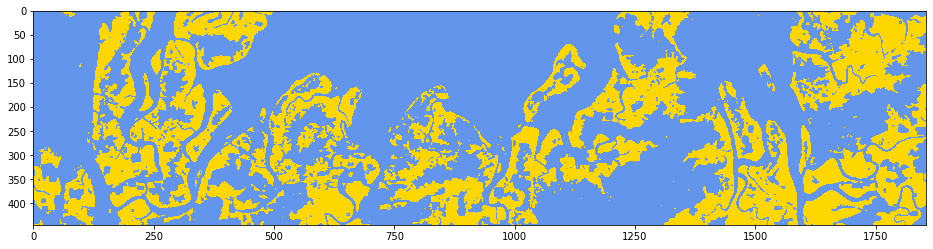


Difference between predicted and labeled mangroves:


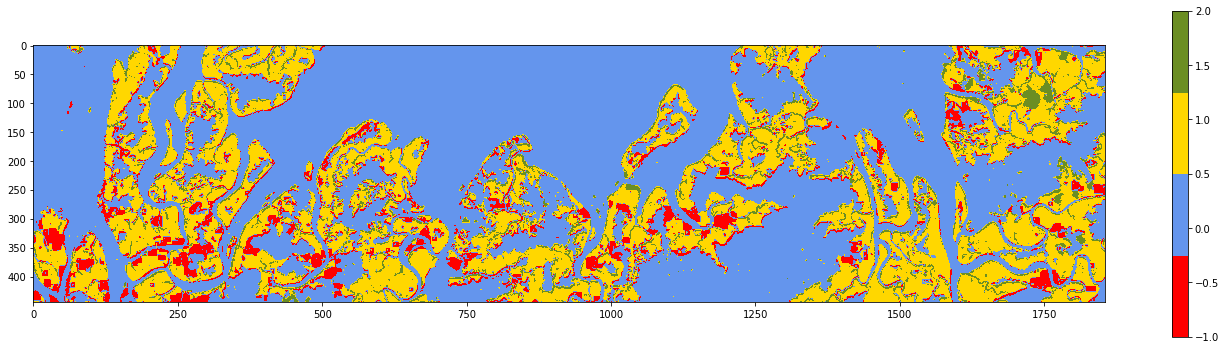

In [16]:
# apply model to new images
# diu.predictOnImageCNN(model, image_base_path + "Florida_1_2020.tif", kSize)
# diu.predictOnImageCNN(model, image_base_path + "Florida_3_2020.tif", kSize)
diu.predictOnImageCNN(model, image_base_path + "Brazil_1_2000.tif", kSize)


In [17]:
print('not now timeout!')

not now timeout!
